<a href="https://colab.research.google.com/github/Sahar-Hassan/theroy-of-compution/blob/main/DFA_minmization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt 
!apt install libgraphviz-dev
!pip install pygraphviz
import pygraphviz

from graphviz import Source 
import matplotlib.pyplot as plt
%matplotlib inline
 

In [ ]:
class DisjointSet(object):

	def __init__(self,items):

		self._disjoint_set = list()

		if items:
			for item in set(items):
				self._disjoint_set.append([item])

	def _get_index(self,item):
		for s in self._disjoint_set:
			for _item in s:
				if _item == item:
					return self._disjoint_set.index(s)
		return None

	def find(self,item):
		for s in self._disjoint_set:
			if item in s:
				return s
		return None

	def find_set(self,item):

		s = self._get_index(item)

		return s+1 if s is not None else None 

	def union(self,item1,item2):
		i = self._get_index(item1)
		j = self._get_index(item2)

		if i != j:
			self._disjoint_set[i] += self._disjoint_set[j]
			del self._disjoint_set[j]
	
	def get(self):
		return self._disjoint_set

In [ ]:
class DFA(object):

	def __init__(self,states_or_filename,terminals=None,start_state=None, \
						transitions=None,final_states=None):
		
		if terminals is None:
			self._get_graph_from_file(states_or_filename)
		else:
			assert isinstance(states_or_filename,list) or \
									 isinstance(states_or_filename,tuple)
			self.states = states_or_filename

			assert isinstance(terminals,list) or isinstance(terminals,tuple)
			self.terminals = terminals

			assert isinstance(start_state,str)
			self.start_state = start_state

			assert isinstance(transitions,dict)
			self.transitions = transitions

			assert isinstance(final_states,list) or \
											isinstance(final_states,tuple)
			self.final_states = final_states

	def draw(self):
		'''
		Draws the dfa using networkx and matplotlib
		'''
		g = nx.DiGraph()

		for x in self.states:
		    g.add_node(x,shape='doublecircle' if x in self.final_states else 'circle',fillcolor='grey' if x == self.start_state else 'white',style='filled')

		temp = defaultdict(list)
		for k,v in self.transitions.items():
		    temp[(k[0],v)].append(k[1])
		
		for k,v in temp.items():    
		    g.add_edge(k[0],k[1],label=','.join(v))


		return Source(nx.drawing.nx_agraph.to_agraph(g))

	def _remove_unreachable_states(self):
		'''
		Removes states that are unreachable from the start state
		'''

		g = defaultdict(list)
		
		for k,v in self.transitions.items():
			g[k[0]].append(v)

		# do DFS
		stack = [self.start_state]

		reachable_states =  set()

		while stack:
			state = stack.pop()

			if state not in reachable_states:
				stack += g[state]
			
			reachable_states.add(state)

		self.states = [state for state in self.states \
								 if state in reachable_states]
		
		self.final_states = [state for state in self.final_states \
								 if state in reachable_states]


		self.transitions = { k:v for k,v in self.transitions.items() \
								if k[0] in reachable_states}



	def minimize(self):

		self._remove_unreachable_states()

		def order_tuple(a,b):
			return (a,b) if a < b else (b,a)

		table = {}

		sorted_states = sorted(self.states)

		# initialize the table
		for i,item in enumerate(sorted_states):
			for item_2 in sorted_states[i+1:]:
				table[(item,item_2)] = (item in self.final_states) != (item_2\
														 in self.final_states)

		flag = True

		# table filling method
		while flag:
			flag = False

			for i,item in enumerate(sorted_states):
				for item_2 in sorted_states[i+1:]:

					if table[(item,item_2)]:
						continue

					# check if the states are distinguishable
					for w in self.terminals:
						t1 = self.transitions.get((item,w),None)
						t2 = self.transitions.get((item_2,w),None)

						if t1 is not None and t2 is not None and t1 != t2:
							marked = table[order_tuple(t1,t2)]
							flag = flag or marked
							table[(item,item_2)] = marked
							
							if marked:
								break

		d = DisjointSet(self.states)

		# form new states
		for k,v in table.items():
			if not v:
				d.union(k[0],k[1])

		self.states = [str(x) for x in range(1,1+len(d.get()))]
		new_final_states = []
		self.start_state = str(d.find_set(self.start_state))

		for s in d.get():
			for item in s:
				if item in self.final_states:
					new_final_states.append(str(d.find_set(item)))
					break

		self.transitions = {(str(d.find_set(k[0])),k[1]):str(d.find_set(v))  
								for k,v in self.transitions.items()}

		self.final_states = new_final_states
 

	def __str__(self):
		'''
		String representation
		'''
		num_of_state = len(self.states)
		start_state = self.start_state
		num_of_final = len(self.final_states)

		return '{} states. {} final states. start state {}'.format( \
										num_of_state,num_of_final,start_state)


	def _get_graph_from_file(self,filename):
		'''
		Load the graph from file
		'''

		with open(filename,'r') as f:

			try:
				lines = f.readlines()
				states,terminals,start_state,final_states = lines[:4]
				
				if states:
					self.states = states[:-1].split()
				else:
					raise Exception('Invalid file format: cannot read states')

				if terminals:
					self.terminals = terminals[:-1].split()
				else:
					raise Exception('Invalid file format: cannot read terminals')

				if start_state:
					self.start_state = start_state[:-1]
				else:
					raise Exception('Invalid file format: cannot read start state')

				if final_states:
					self.final_states = final_states[:-1].split()
				else:
					raise Exception('Invalid file format: cannot read final states')

				lines = lines[4:]

				self.transitions = {}

				for line in lines:
					current_state,terminal,next_state = line[:-1].split()

					self.transitions[(current_state,terminal)] = next_state

			except Exception as e:
				print("ERROR: ",e)





In [ ]:
! cat  GRAPH.txt

A B C D E F H G I K
0 1
A
E
A 0 B 
A 1 C 
B 0 C 
B 1 D 
C 0 E 
C 1 F 
D 0 G 
D 1 F 
E 0 D 
E 1 B   
F 0 D 
F 1 H 
H 0 I 
H 1 D 
G 0 H 
G 1 I 
I 0 I 
I 1 F 
K 0 F 
K 1 I 
  

ERROR:  not enough values to unpack (expected 3, got 0)


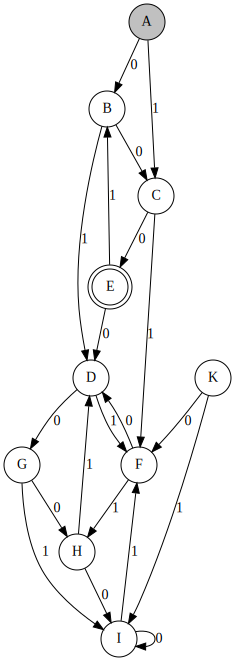

In [ ]:

# initialize DFA from file
filename = 'GRAPH.txt'
dfa = DFA(filename)
dfa.draw() 

In [ ]:
# minimize dfa
dfa.minimize()
dfa.__str__()
print (dfa.states)
print (dfa.start_state )

print (dfa.final_states)


['1', '2', '3', '4', '5']
5
['1']


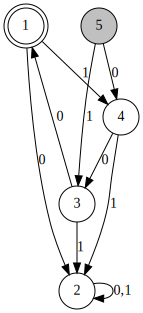

In [ ]:
# draw minimized dfa
dfa.draw()
 